## Loading modules

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gp
from geopy import distance
import datetime as dt
import matplotlib.pyplot as plt

## Accessing data

In [2]:
session = cc.database.create_session()

### Extracting data for SO and dealing with sea ice data

In [3]:
def getACCESSdata_SO(var, start, end, freq, ses, minlat = -90, maxlat = -45, 
                  exp = '01deg_jra55v140_iaf_cycle2', ice_data = False):
    #If data being accessed is an ice related variable, then apply the following steps
    if ice_data == True:
        #Accessing data
        vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end, decode_coords = False)
        #Accessing corrected coordinate data to update geographical coordinates in the array of interest
        area_t = cc.querying.getvar(exp, 'area_t', ses, n = 1)
        #Apply time correction so data appears in the middle (12:00) of the day rather than at the beginning of the day (00:00)
        vararray['time'] = vararray.time.to_pandas() - dt.timedelta(hours = 12)
        #Change coordinates so they match ocean dimensions 
        vararray.coords['ni'] = area_t['xt_ocean'].values
        vararray.coords['nj'] = area_t['yt_ocean'].values
        #Rename coordinate variables so they match ocean data
        vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
        #Drop coordinates that are no longer needed
        if len(vararray.coords) > 3:
            vararray = vararray.drop([i for i in vararray.coords if i not in ['time', 'xt_ocean', 'yt_ocean']])
    else:
        #Accessing data
        vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end)
    #Subsetting data to area of interest
    vararray = vararray.sel(yt_ocean = slice(minlat, maxlat))
    return vararray

## Loading data

In [205]:
var_ice = getACCESSdata_SO('aice_m', '1978-01', '1978-03', freq =  '1 monthly', 
                           ses = session, exp = '01deg_jra55v140_iaf_cycle4', 
                           ice_data = True)

In [5]:
var_ice = var_ice.sel(xt_ocean = slice(-270, -269))
var_ice

<xarray.DataArray 'aice_m' (time: 3, yt_ocean: 21, xt_ocean: 10)>
dask.array<getitem, shape=(3, 21, 10), dtype=float32, chunksize=(1, 21, 10), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 1978-02-28T12:00:00
  * xt_ocean  (xt_ocean) float64 -269.9 -269.8 -269.7 ... -269.2 -269.1 -269.0
  * yt_ocean  (yt_ocean) float64 -61.98 -61.94 -61.89 ... -61.13 -61.08 -61.03
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where is more or equal than 0.1 and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original NA values from cumulative.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

In [206]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(var_ice >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'yt_ocean', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('yt_ocean'), 1, 0).where(~np.isnan(var_ice))

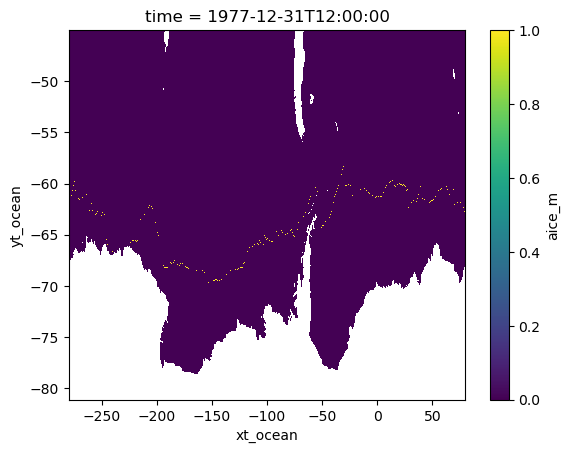

In [207]:
ice_10[0].plot()

### Checking results

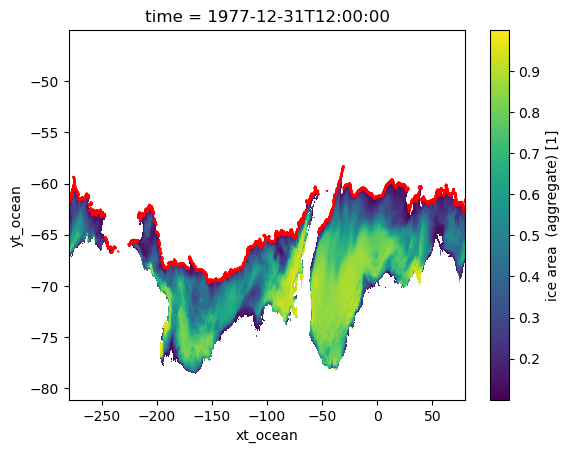

In [208]:
#Checking results for first time step
fig = plt.figure()
ax = fig.add_subplot(111)
var_ice.where(var_ice >= 0.1)[0].plot(ax = ax)
ice_10[0].plot.contour(ax = ax, colors = ['red'])

In [211]:
ice_10 = ice_10[0].sel(yt_ocean = slice(-70, -55), xt_ocean = slice(-270, -200))

## Getting indices for sea ice edge
We will find the index for the sea ice edge so we can identify the latitude at which the sea ice edge occurs.

In [212]:
#Getting the indices for pixel with maximum value along yt_ocean dimension
edge_ind = ice_10.argmax(dim = 'yt_ocean')

#Saving sea ice edge for future reference
# edge_ind.to_netcdf('/g/data/v45/la6889/Calculations/C2_Crabeaters/SeaIceEdge/SeaIceEdge_Dec1977-Dec2018.nc')

## Looping through each time step to get the sea ice edge data

In [ ]:
#Getting latitude values where pixel has maximum value
for t in ice_10.time:
    ed_t = edge_ind.sel(time = t)
    ice_edge = pd.DataFrame({'lat': [ice_10.yt_ocean[i].values.tolist() for i in ed_t.values],
                             #We keep all longitude values
                             'lon': ice_10.xt_ocean.values})

#Checking first 10 results
ice_edge.head(10)

In [213]:
ice_edge = pd.DataFrame({'lat': ice_10.yt_ocean[edge_ind[0].values].values,
                         #We keep all longitude values
                         'lon': ice_10.xt_ocean.values})
ice_edge

,lat,lon
0,-61.558813,-269.95
1,-61.558813,-269.85
2,-61.558813,-269.75
3,-61.558813,-269.65
4,-61.558813,-269.55
...,...,...
695,-61.558813,-200.45
696,-61.558813,-200.35
697,-61.558813,-200.25
698,-61.558813,-200.15


## Defining function to identify the closest ice edge pixel for each coordinate pair in original data

In [188]:
def min_dist(lat, lon, ice_edge):
    dist = pd.DataFrame()
    dist['Dist'] = ice_edge.apply(lambda row: distance.distance((row.lat, row.lon), (lat, lon)).km, axis = 1)
    min_dist = dist.Dist.iloc[dist['Dist'].argmin()]
    return min_dist

### Testing function with one point in pandas dataframe

In [166]:
test = pd.DataFrame({'lat': [-59.49310348], 'lon': [-269.95]})
test

,lat,lon
0,-59.493103,-269.95


In [214]:
min_dist(test.lat.iloc[0], test.lon.iloc[0], ice_edge)

230.16361275549949

### Testing function using points directly from data array

In [215]:
min_dist(ice_10.yt_ocean[-10], ice_10.xt_ocean[0], ice_edge = ice_edge)

672.3460028458962

## Using numpy vectorisation

In [216]:
#Getting pairs of coordinates for each pixel
coords_df = []

for y in ice_10.yt_ocean:
    for x in ice_10.xt_ocean:
        coords_df.append([y.values.tolist(), x.values.tolist()])

In [187]:
def min_dist_np(np, ice_edge):
    dist = pd.DataFrame()
    dist['Dist'] = ice_edge.apply(lambda row: distance.distance((row.lat, row.lon), (np[0], np[1])).km, axis = 1)
    min_dist = dist.Dist.iloc[dist['Dist'].argmin()]
    return min_dist

In [ ]:
test_apply = np.apply_along_axis(min_dist_np, 1, coords_df, ice_edge)

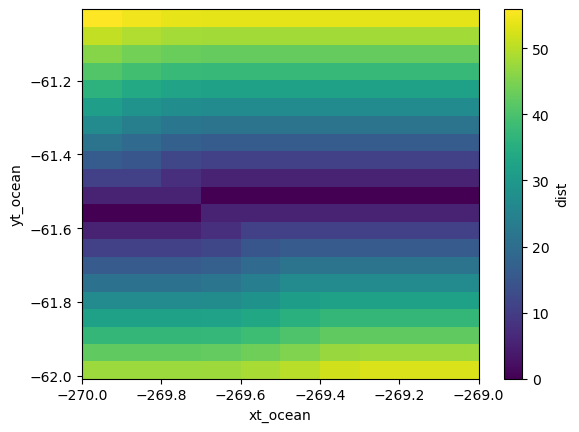

In [201]:
dist_np = xr.DataArray(data = np.reshape(test_apply, ice_10.shape),
                       dims = ["yt_ocean", "xt_ocean"], 
                       coords = dict(xt_ocean = ice_10.xt_ocean.values, 
                                     yt_ocean = ice_10.yt_ocean.values),
                          name = 'dist')

dist_np.plot()

This option works well for small amounts of data, but as the number of pixels increase, the calculations take a long time. The calculation above, which includes   pixels, took    minutes to complete.

# Work in progress
From this point on nothing appears to be working. This section is very untidy, but it shows what I have been trying so far.

In [103]:
# def min_dist(lat, lon, ice_edge):
#     # ice_edge = kwargs.get('ice_edge')
#     dist = pd.DataFrame()
#     dist['Dist'] = lat*lon
#     # dist['Dist'] = ice_edge.apply(lambda row: distance.distance((row.lat, row.lon), 
#     #                                                                 (lat, lon)).km, axis = 1)
#     # dist['Dist'] = [distance.distance((ice_edge.lat.iloc[i], ice_edge.lon.iloc[i]), (lat, lon)).km for i in ice_edge.index]
#     closest = dist.Dist.iloc[dist['Dist'].argmin()]
#     return closest

def test(lat, lon, lat_edge, lon_edge):
    fun = lambda x1, y1, x2, y2: (x1-x2)+(y1-y2)
    return xr.apply_ufunc(fun, lat, lon, lat_edge, lon_edge,
                          input_core_dims = [['yt_ocean'], [], ['yt_ocean'], []],
                          # exclude_dims = set(('xt_ocean')),
                          output_core_dims = [['yt_ocean']],
                          vectorize = True,
                         dask = "parallelized")

In [153]:
# def looping(
def test(lat, lon):
    # fun = lambda x1, y1: [print(i) for i in y1
    def summing(x, y):
        sum_ = x+y
        print(sum_.min(axis = 0))
        return sum_.min(axis = 0)
    return xr.apply_ufunc(summing, lat, lon,
                          input_core_dims = [['yt_ocean'], ['xt_ocean']],
                          # exclude_dims = set(('xt_ocean')),
                          output_core_dims = [['yt_ocean'], []],#'xt_ocean']],
                          vectorize = True,
                         dask = "parallelized")

In [154]:
test(ice_10.yt_ocean, ice_10.yt_ocean)
# [print(i) for i in ice_10.xt_ocean].max()

ValueError: operand to apply_ufunc has required core dimensions ['xt_ocean'], but some of these dimensions are absent on an input variable: ['xt_ocean']

In [148]:
# ice_10.yt_ocean[edge_ind[0].values][0]
ice_10.xt_ocean

<xarray.DataArray 'xt_ocean' (xt_ocean: 10)>
array([-269.95, -269.85, -269.75, -269.65, -269.55, -269.45, -269.35, -269.25,
       -269.15, -269.05])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -269.9 -269.8 -269.7 ... -269.2 -269.1 -269.0

In [122]:
def outer(x):
    def inner(y):
        return x + y
    return inner

In [124]:
add_five = outer(5)
result = add_five(6)
print(result)  # prints 11

11


In [109]:
testing = np.reshape(np.repeat(ice_10.yt_ocean.values.tolist(), len(ice_10.xt_ocean.values)), ice_10[0].shape)

In [ ]:
np.repeat(ice_10.yt_ocean.values.tolist(), len(ice_10.xt_ocean.values))

In [62]:
ice_10.sel(yt_ocean = lat_vals[0,0].values)

<xarray.DataArray 'aice_m' (time: 6, xt_ocean: 3600)>
dask.array<getitem, shape=(6, 3600), dtype=float64, chunksize=(1, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 1978-05-31T12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    yt_ocean  float64 -81.11

## Getting coordinates for entire data array

In [24]:
#Making a grid with all coordinate combinations
x, y = np.meshgrid(var_ice.xt_ocean.values, var_ice.yt_ocean.values)

In [78]:
y

array([[-81.10863168, -81.10863168, -81.10863168, ..., -81.10863168,
        -81.10863168, -81.10863168],
       [-81.06639232, -81.06639232, -81.06639232, ..., -81.06639232,
        -81.06639232, -81.06639232],
       [-81.02415297, -81.02415297, -81.02415297, ..., -81.02415297,
        -81.02415297, -81.02415297],
       ...,
       [-45.17722923, -45.17722923, -45.17722923, ..., -45.17722923,
        -45.17722923, -45.17722923],
       [-45.10669393, -45.10669393, -45.10669393, ..., -45.10669393,
        -45.10669393, -45.10669393],
       [-45.03607147, -45.03607147, -45.03607147, ..., -45.03607147,
        -45.03607147, -45.03607147]])

In [31]:
print(x[500,100], y[500, 100])

-269.9499999999977 -59.49310348481155


In [73]:
lat_vals = xr.DataArray(data = np.repeat(ice_10.yt_ocean.values, len(ice_10.xt_ocean.values)), dims = ["yt_ocean", "xt_ocean"], 
                        coords = dict(xt_ocean = ice_10.xt_ocean.values, yt_ocean = ice_10.yt_ocean.values), name = "lat")
lon_vals = xr.DataArray(data = x, dims = ["yt_ocean", "xt_ocean"], coords = dict(xt_ocean = ice_10.xt_ocean.values, yt_ocean = ice_10.yt_ocean.values),
                          name = "lon")

ValueError: different number of dimensions on data and dims: 1 vs 2

<xarray.DataArray 'lon' ()>
array(-269.95)
Coordinates:
    xt_ocean  float64 -269.9
    yt_ocean  float64 -59.49

In [27]:
#Calculating how many pixels there are in total
pixels = ice_10[0].shape[0]*ice_10[0].shape[1]

#Creating pandas with coordinate combination
coords_all = pd.DataFrame({'lat': y.reshape(pixels), 'lon': x.reshape(pixels)})
coords_all.head()

,lat,lon
0,-81.108632,-279.95
1,-81.108632,-279.85
2,-81.108632,-279.75
3,-81.108632,-279.65
4,-81.108632,-279.55


In [29]:
x = coords_all.to_numpy()
x[0]

array([ -81.10863168, -279.95      ])

### Defining `numpy` friendly version of distance function

In [28]:
def min_dist_np(point, ice_edge):
    ice_edge['Dist'] = ice_edge.apply(lambda row: distance.distance((row.lat, row.lon), (point[0], point[1])).km, axis = 1)
    geoseries = ice_edge.iloc[ice_edge['Dist'].argmin()]
    return geoseries['Dist']

In [30]:
min_dist_np(x[0], ice_edge)

1405.6036741299097

In [130]:
def min_dist2(point_lat, point_lon, ice_edge):
    ice_edge['Dist'] = ice_edge.apply(lambda row: distance.distance((row.lat, row.lon), (point_lat, point_lon)).km, axis = 1)
    geoseries = ice_edge.iloc[ice_edge['Dist'].argmin()]
    return geoseries['Dist']

In [103]:
def _inner(la, lon, ice_edge):
    ice_edge['Dist'] = ice_edge.apply(lambda row: distance.distance((row.lat, row.lon), (la, lon)).km, axis = 1)
    geoseries = ice_edge.iloc[ice_edge['Dist'].argmin()]
    return geoseries['Dist']

def testing(a, b):
    return xr.apply_ufunc(_inner, a, b)

In [134]:
test = []
for i, la in enumerate(ice_10[0].yt_ocean):
    test.append(min_dist2(la.values, ice_10[0].xt_ocean[i].values, ice_edge))

In [144]:
test_da = xr.DataArray(data = np.array(test).reshape(ice_10[0].yt_ocean.shape),
             dims = ["yt_ocean"], 
             coords = dict(yt_ocean = ice_10[0].yt_ocean.values),
                          name = "vals")
test_da

<xarray.DataArray 'vals' (yt_ocean: 740)>
array([1405.60367413, 1401.48966657, 1397.38865144, 1393.30081093,
       1389.22632897, 1385.16539118, 1381.11818492, 1377.08489928,
       1373.06572509, 1369.0608549 , 1365.07048304, 1361.09480557,
       1357.13402032, 1353.18832687, 1349.25792657, 1345.34302254,
       1341.44381967, 1337.56052461, 1333.6933458 , 1329.84249344,
       1326.00817952, 1322.19061777, 1318.39002373, 1314.60661467,
       1310.84060966, 1307.09222951, 1303.3616968 , 1299.64923584,
       1295.95507273, 1292.27943525, 1288.62255296, 1284.98465713,
       1281.36598072, 1277.76675842, 1274.1872266 , 1270.62762329,
       1267.08818822, 1263.56916274, 1260.07078984, 1256.59331412,
       1253.13698179, 1249.70204064, 1246.28874   , 1242.89733074,
       1239.52806525, 1236.1811974 , 1232.85698253, 1229.55567742,
       1226.27754022, 1223.02283051, 1219.79180917, 1216.58473841,
       1213.40188172, 1210.24350383, 1207.10987068, 1204.00124935,
       1200.91790808, 1197.86011618, 1194.82814398, 1191.82226285,
       1188.84274506, 1185.8898638 , 1182.96389313, 1180.06510786,
       1177.19378359, 1174.35019658, 1171.53462374, 1168.74734254,
       1165.98863097, 1163.25876747, 1160.55803086, 1157.88670028,
       1155.24505515, 1152.63337505, 1149.93375866, 1147.26306665,
       1144.62235352, 1142.01190383, 1139.43200221, 1136.88293336,
...
       1782.00312165, 1789.73823819, 1797.49752901, 1805.28085072,
       1813.08811395, 1820.91917799, 1828.77395596, 1836.6523098 ,
       1844.55415508, 1852.4793563 , 1860.42783141, 1868.39944744,
       1876.39412468, 1884.41173262, 1892.45219382, 1900.51538019,
       1908.6012165 , 1916.70957701, 1924.84038868, 1932.99352807,
       1941.16892424, 1949.36645599, 1957.58605446, 1965.82760065,
       1974.09102769, 1982.37621874, 1990.68310889, 1999.01158338,
       2007.36157921, 2015.73298367, 2024.12573561, 2032.53972433,
       2040.97489047, 2049.43112528, 2057.90837118, 2066.40652129,
       2074.92551975, 2083.46526154, 2092.02569248, 2100.60670932,
       2109.20825953, 2117.83024161, 2126.4726046 , 2135.13524874,
       2143.81812458, 2152.52113404, 2161.24422917, 2169.98731349,
       2178.75034053, 2187.5332154 , 2196.33589302, 2205.15828005,
       2214.00033278, 2222.86195939, 2231.74311749, 2240.64371672,
       2249.563716  , 2258.50302638, 2267.46160805, 2276.43937344,
       2285.43628396, 2294.45225341, 2303.48724437, 2312.51868652,
       2321.55311928, 2330.60653528, 2339.67889829, 2348.77012479,
       2357.88017965, 2367.00898059, 2376.15649352, 2385.32263735,
       2394.50737905, 2403.71063868, 2412.93238421, 2422.17253684,
       2431.43106551, 2440.7078925 , 2450.00298771, 2459.31627451])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04

In [129]:
for i, la in enumerate(ice_10[0].yt_ocean[0:10]):
    print(la.values, ice_10[0].xt_ocean[0:10][i].values)

-81.10863167835483 -279.95
-81.06639232397434 -279.84999999999997
-81.02415296959386 -279.74999999999994
-80.98191361521337 -279.6499999999999
-80.93967426083289 -279.5499999999999
-80.8974349064524 -279.4499999999999
-80.85519555207192 -279.34999999999985
-80.81295619769143 -279.24999999999983
-80.77071684331095 -279.1499999999998
-80.72847748893047 -279.0499999999998


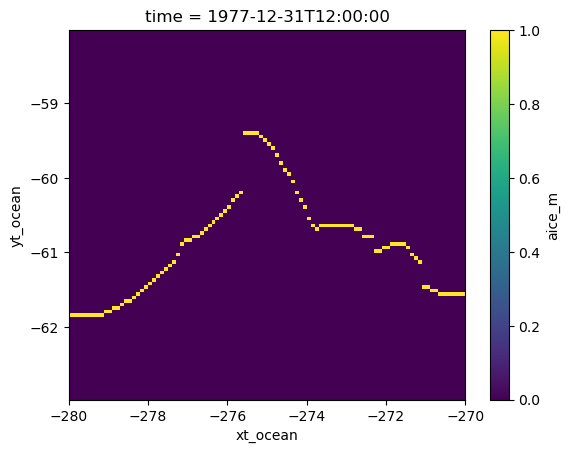

In [39]:
test_da = ice_10[0].sel(yt_ocean = slice(-63, -58), xt_ocean = slice(-280, -270))
test_da.plot()

In [38]:
lat_vals = xr.DataArray(data = y, dims = ["yt_ocean", "xt_ocean"], coords = dict(xt_ocean = ice_10.xt_ocean.values, yt_ocean = ice_10.yt_ocean.values),
                          name = "lat").sel(yt_ocean = slice(-63, -58), xt_ocean = slice(-280, -270))
lon_vals = xr.DataArray(data = x, dims = ["yt_ocean", "xt_ocean"], coords = dict(xt_ocean = ice_10.xt_ocean.values, yt_ocean = ice_10.yt_ocean.values),
                          name = "lon").sel(yt_ocean = slice(-63, -58), xt_ocean = slice(-280, -270))

In [77]:
x = testing(lat_vals, lon_vals)

[[-62.9550501  -62.9550501  -62.9550501  ... -62.9550501  -62.9550501
  -62.9550501 ]
 [-62.90954591 -62.90954591 -62.90954591 ... -62.90954591 -62.90954591
  -62.90954591]
 [-62.86397079 -62.86397079 -62.86397079 ... -62.86397079 -62.86397079
  -62.86397079]
 ...
 [-58.14721617 -58.14721617 -58.14721617 ... -58.14721617 -58.14721617
  -58.14721617]
 [-58.09440327 -58.09440327 -58.09440327 ... -58.09440327 -58.09440327
  -58.09440327]
 [-58.04151192 -58.04151192 -58.04151192 ... -58.04151192 -58.04151192
  -58.04151192]] [[-279.95 -279.85 -279.75 ... -270.25 -270.15 -270.05]
 [-279.95 -279.85 -279.75 ... -270.25 -270.15 -270.05]
 [-279.95 -279.85 -279.75 ... -270.25 -270.15 -270.05]
 ...
 [-279.95 -279.85 -279.75 ... -270.25 -270.15 -270.05]
 [-279.95 -279.85 -279.75 ... -270.25 -270.15 -270.05]
 [-279.95 -279.85 -279.75 ... -270.25 -270.15 -270.05]]


ValueError: applied function returned data with unexpected number of dimensions. Received 0 dimension(s) but expected 2 dimensions with names: ('yt_ocean', 'xt_ocean')

In [80]:
y.shape

(740, 3600)